## Log-Transformed Acqusition Functions
A common problem when using acquisition functions is vanishing gradients in regions
of parameter space that are nearly zero. This happens often when using Expected
Improvement or Constraint probability weighting. To address this, [1] suggests taking
 the log of the acquisition function to make numerical optimization more robust. We
 demonstrate this feature in Xopt. Compare acquisition function plots shown here to
 those in the constrained BO tutorial.

[1] Ament, Sebastian, et al. "Unexpected improvements to expected improvement for bayesian optimization." arXiv preprint arXiv:2310.20708 (2023).

## Define the test problem
Here we define a simple optimization problem, where we attempt to minimize the sin
function in the domian [0,2*pi]. Note that the function used to evaluate the
objective function takes a dictionary as input and returns a dictionary as the output.

In [1]:
from xopt.vocs import VOCS
import math

# define variables and function objectives
vocs = VOCS(
    variables={"x": [0, 2 * math.pi]},
    objectives={"f": "MINIMIZE"},
)

In [2]:
# define a test function to optimize
import numpy as np

def sin_function(input_dict):
    return {"f": np.sin(input_dict["x"])}

## Create Xopt objects
Create the evaluator to evaluate our test function and create a generator that uses
the Upper Confidence Bound acquisition function to perform Bayesian Optimization.

In [3]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt import Xopt

evaluator = Evaluator(function=sin_function)
generator = ExpectedImprovementGenerator(vocs=vocs, log_transform_acquisition_function=True)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

## Generate and evaluate initial points
To begin optimization, we must generate some random initial data points. The first call
to `X.step()` will generate and evaluate a number of randomly points specified by the
 generator. Note that if we add data to xopt before calling `X.step()` by assigning
 the data to `X.data`, calls to `X.step()` will ignore the random generation and
 proceed to generating points via Bayesian optimization.

In [4]:
# call X.random_evaluate() to generate + evaluate 3 initial points
X.random_evaluate(2)

# inspect the gathered data
X.data

,x,f,xopt_runtime,xopt_error
0,4.579408,-0.991171,0.000004,False
1,1.149406,0.912521,0.000001,False


## Do bayesian optimization steps
To perform optimization we simply call `X.step()` in a loop. This allows us to do
intermediate tasks in between optimization steps, such as examining the model and
acquisition function at each step (as we demonstrate here).

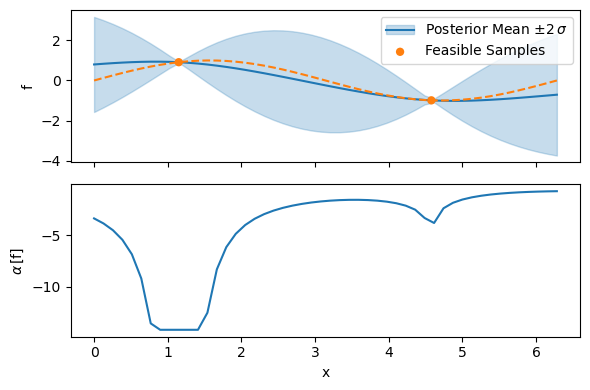

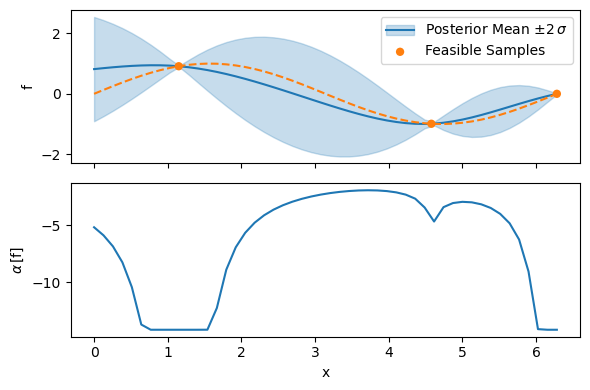

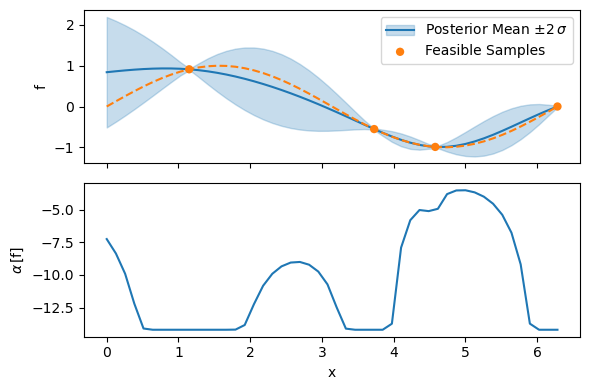

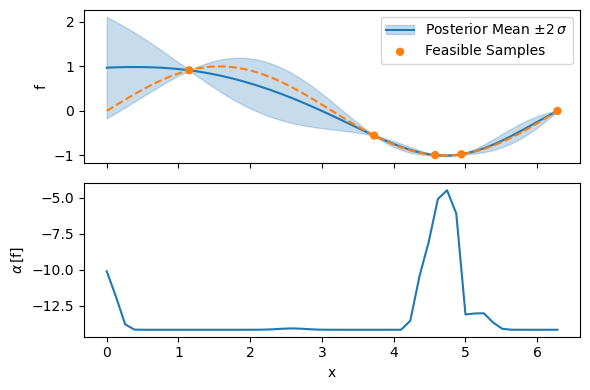

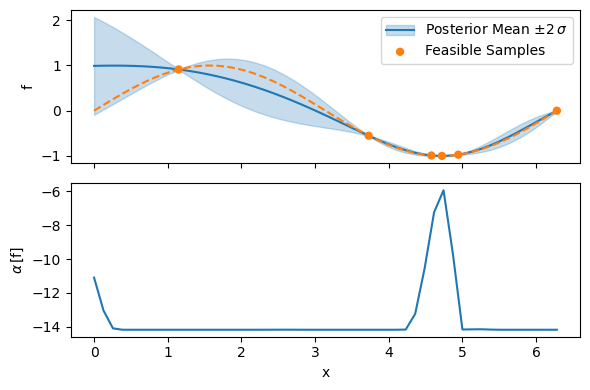

In [5]:
import torch

n_steps = 5

# test points for plotting
test_x = torch.linspace(*X.vocs.bounds.flatten(), 50).double()

for i in range(n_steps):
    # get the Gaussian process model from the generator
    model = X.generator.train_model()

    # visualize model
    fig, ax = generator.visualize_model(n_grid=len(test_x))
    
    # plot true function
    true_f = sin_function({"x": test_x})["f"]
    gt = ax[0].plot(test_x, true_f, "C1--")

    # do the optimization step
    X.step()

In [6]:
# access the collected data
X.data

,x,f,xopt_runtime,xopt_error
0,4.579408,-9.911710e-01,0.000004,False
1,1.149406,9.125210e-01,0.000001,False
2,6.283185,-2.449294e-16,0.000004,False
3,3.728141,-5.534894e-01,0.000003,False
4,4.944302,-9.732284e-01,0.000003,False
5,4.722263,-9.999513e-01,0.000003,False
6,4.721998,-9.999538e-01,0.000004,False


## Getting the optimization result
To get the best point (without evaluating it) we ask the generator to
predict the optimum based on the posterior mean.

In [7]:
X.generator.get_optimum()

,x
0,4.717988


## Customizing optimization
Each generator has a set of options that can be modified to effect optimization behavior

In [8]:
X.generator.dict()

{'model': ModelListGP(
   (models): ModuleList(
     (0): SingleTaskGP(
       (likelihood): GaussianLikelihood(
         (noise_covar): HomoskedasticNoise(
           (noise_prior): GammaPrior()
           (raw_noise_constraint): GreaterThan(1.000E-04)
         )
       )
       (mean_module): ConstantMean()
       (covar_module): ScaleKernel(
         (base_kernel): MaternKernel(
           (lengthscale_prior): GammaPrior()
           (raw_lengthscale_constraint): Positive()
         )
         (outputscale_prior): GammaPrior()
         (raw_outputscale_constraint): Positive()
       )
       (outcome_transform): Standardize()
       (input_transform): Normalize()
     )
   )
   (likelihood): LikelihoodList(
     (likelihoods): ModuleList(
       (0): GaussianLikelihood(
         (noise_covar): HomoskedasticNoise(
           (noise_prior): GammaPrior()
           (raw_noise_constraint): GreaterThan(1.000E-04)
         )
       )
     )
   )
 ),
 'n_monte_carlo_samples': 128,
 'turbo_